## HECO Cooling Loop A - 2. Data Processing

#### <span style="color:red; font-weight:bold"> Instructions for Using this Jupyter Notebook:</span>

<span style="color:royalblue">(1) Place **data_clean.py** and this Notebook in the same folder.</span>

<span style="color:royalblue">(2) Place **vitality_v5_meter_issues.xlsx** and the downloaded raw data files in the same directory ("input_dir").</span> 
- Click <a href="https://docs.google.com/spreadsheets/d/1YscZJJUDKwv0iPNNVlcVcA-98xsGtkk_/edit?usp=share_link&ouid=103697198955047775504&rtpof=true&sd=true" style="color: royalblue; text-decoration: underline; font-weight: bold;">here</a> to download this .xlsx file
- Additionally, the filename of the raw data files should include the variable name (i.e., kw, kwh, tons, or tonhrs).

<span style="color:royalblue">(3) Only need to modify the **Parameters in Section 1.0** to use this Notebook:</span> 
- Change the **Data Directories (dir)** to your own directories
  - Ensure that **input_dir** here matches the **output_dir** in *1.combine_data.ipynb*
- Select a **Variable (var)** from **kw, kwh, tons, or tonhrs**
- Run the Notebook once for each variable change to generate the corresponding data outputs

<span style="color:royalblue">(4) Explanation of the "CHECK THE CONDITION" section:</span> 
- This section is placed **before 2.2 Interpolation**, and the checking process is automated in this Notebook (NO code adjustments are needed). \
The following two conditions apply:

  1. If the parameter setting has **var = 'kw' or 'tons'**, the Notebook will stop running just before Interpolation, displaying an error message: "Condition not met. Stopping execution."
  2. If the parameter setting has **var = 'kwh' or 'tonhrs'** (variables that can be linearly interpolated), the Notebook will continue running until the end.

## Contents
* [1. Preprocessing Downloaded Data](#1)
  * [1.0 Input Parameters](#1.0)
  * [1.1 Imports](#1.1)
  * [1.2 Load Data](#1.2)
  * [1.3 Plot and Reshape Data](#1.3)
  * [1.4 Save Data for Uploading (Original)](#1.4)
* [2. Interpolation](#2)  
  * [2.1 Handle Meter Issues](#2.1)
  * [CHECK THE CONDITION](#check)
  * [2.2 Interpolation](#2.2)  
  * [2.3 Save Data for Uploading (Interpolated)](#2.3)
* [3. Interval](#3)
  * [3.1 Calculate Interval](#3.1)
  * [3.2 Save Data for Uploading (Interval)](#3.2)

## 1. Preprocessing Downloaded Data<a id='1'></a>

### 1.0 Input Parameters<a id='1.0'></a>

In [1]:
########## CHANGE DATA DIRECTORIES & VARIABLE ##########

# Data Directories
input_dir = '../../data/downloads/'  # directory for downloaded raw data files

output_dir = '../../data/outputs/'  # directory for data outputs (different from input_dir)

plot_dir = '../../data/outputs/plots/'  # directory for plot outputs

# Variable to specify the file name filter: kw, kwh, tons, tonhrs
var = 'kwh'

# Estimated maximum number of consecutive sudden drops 
interp_window = 30

# Meter issues file
issues_file = input_dir + 'vitality_v5_meter_issues.xlsx'

# Data Frequency
freq = '15min'

# Schema
schema = 'vitality_v5'

######################################################

### 1.1 Imports<a id='1.1'></a>

In [2]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
# import psycopg2

import data_clean as dc  # import self-defined module

### 1.2 Load Data<a id='1.2'></a>

In [3]:
file_path = dc.find_matching_csvs(input_dir, var)
df = pd.read_csv(file_path[0], low_memory=False)
df["datetime"] = pd.to_datetime(df["datetime"])
df.head(3)

,datetime,ab_chwmtr_v1,hh_chwmtr_v2,wh_chwmtr_v1,hh_mtr_a,hh_mtr_b,ab_mtr_1,wh_mtr_1,sh_mtr_1,hs_mtr_1
0,2021-07-01 00:00:00,1249797.02,10854315.46,195970.7,5559925.0,22813084.0,3622764.0,10339308.0,4095888.0,221368.0
1,2021-07-01 00:15:00,1249806.92,10854420.66,195972.9,5559965.0,22813220.0,3622791.0,10339337.0,4095899.0,221370.0
2,2021-07-01 00:30:00,1249816.52,10854528.46,195975.2,5559992.0,22813377.0,3622817.0,10339367.0,4095908.0,221371.0


### 1.3 Plot and Reshape data<a id='1.3'></a>

##### <span style="color:blue">Plot original data:</span>

Plot saved to ../../data/outputs/plots/kwh_original.pdf


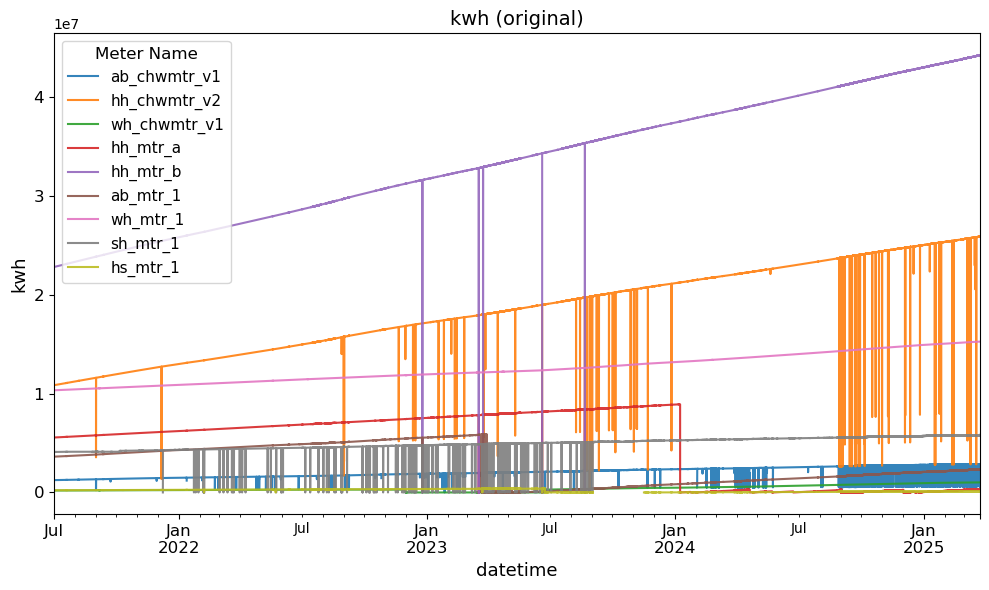

In [4]:
dc.plot_data(df, var, "original", plot_dir)

##### <span style="color:blue">Reshape df with columns ['datetime', 'meter_name', 'meter_reading']:</span>

In [5]:
reshaped_df = dc.reshape_merged_df(df)
display(Markdown(f"<span style='color:blue; font-weight:bold'>Table of Original {var}:</span>"))
reshaped_df.head(10)

<span style='color:blue; font-weight:bold'>Table of Original kwh:</span>

,datetime,meter_name,meter_reading
0,2021-07-01 00:00:00,ab_chwmtr_v1,1249797.02
1,2021-07-01 00:00:00,ab_mtr_1,3622764.00
2,2021-07-01 00:00:00,hh_chwmtr_v2,10854315.46
3,2021-07-01 00:00:00,hh_mtr_a,5559925.00
4,2021-07-01 00:00:00,hh_mtr_b,22813084.00
5,2021-07-01 00:00:00,hs_mtr_1,221368.00
6,2021-07-01 00:00:00,sh_mtr_1,4095888.00
7,2021-07-01 00:00:00,wh_chwmtr_v1,195970.70
8,2021-07-01 00:00:00,wh_mtr_1,10339308.00
9,2021-07-01 00:15:00,ab_chwmtr_v1,1249806.92


### 1.4 Save Data for Uploading (Original)<a id='1.4'></a>

In [6]:
# Extract the min and max datetime
min_datetime = df["datetime"].min().strftime('%Y-%m-%d_%H-%M-%S')
max_datetime = df["datetime"].max().strftime('%Y-%m-%d_%H-%M-%S')

# Create the file name with the variable
file_name = f"{var}_{schema}_{min_datetime}_{max_datetime}.csv"

# Save file
dc.save_file(reshaped_df, file_name, output_dir)  # for uploading

Writing file: "../../data/outputs/kwh_vitality_v5_2021-07-01_00-00-00_2025-03-24_23-45-00.csv"


## 2. Interpolation<a id='2'></a>

### 2.1 Handle Meter Issues<a id='2.1'></a>

Meter issues are recoded in the file "vitality_v5_meter_issues.xlsx".

In [7]:
fixed_df = dc.fix_meter_issues(var, issues_file, df)

#### <span style="color:red; font-weight:bold">CHECK THE CONDITION:</span><a id='check'></a>

**If var = "kwh" or "tonhrs"** (monotonically increasing), **proceed to Section 2.2** for linear interpolation.

**Otherwise**, replace the values at locations with meter issues with missing values (NaN), **save the data** to a CSV file with a name ending in **"_with_null**," and **terminate** execution with the error message: **"Condition not met. Stopping execution."**

In [8]:
if var in ["kwh", "tonhrs"]:
    print("Condition met. Continuing execution...")
else:
    # Reshape the dataframe
    reshaped_fixed_df = dc.reshape_merged_df(fixed_df)
    # Add an 'is_missing' column: 1 for NaN values, 0 otherwise
    reshaped_fixed_df['is_missing'] = reshaped_fixed_df['meter_reading'].isna().astype(int)
    # Save file
    file_name_m = f"{var}_{schema}_{min_datetime}_{max_datetime}_with_null.csv"
    dc.save_file(reshaped_fixed_df, file_name_m, output_dir)
    # Stop running the following codes
    raise RuntimeError("Condition not met. Stopping execution.")

Condition met. Continuing execution...


### 2.2 Interpolation<a id='2.2'></a>
Only for **kwh** and **tonhrs**

In [9]:
# Copy data into a new dataframe
data = fixed_df.set_index("datetime")

# Create a DataFrame to track interpolation
interpolation_flags = pd.DataFrame(0, index=data.index, columns=[f'{col}_interpolated' \
                                                               for col in data.columns])

# Apply the cleaning and interpolation function to each column
for col in data.columns:
    data[col] = dc.clean_and_interpolate(data[col], interp_window, interpolation_flags[f'{col}_interpolated'])

##### <span style="color:blue">Plot cleaned data:</span>

Plot saved to ../../data/outputs/plots/kwh_interpolated.pdf


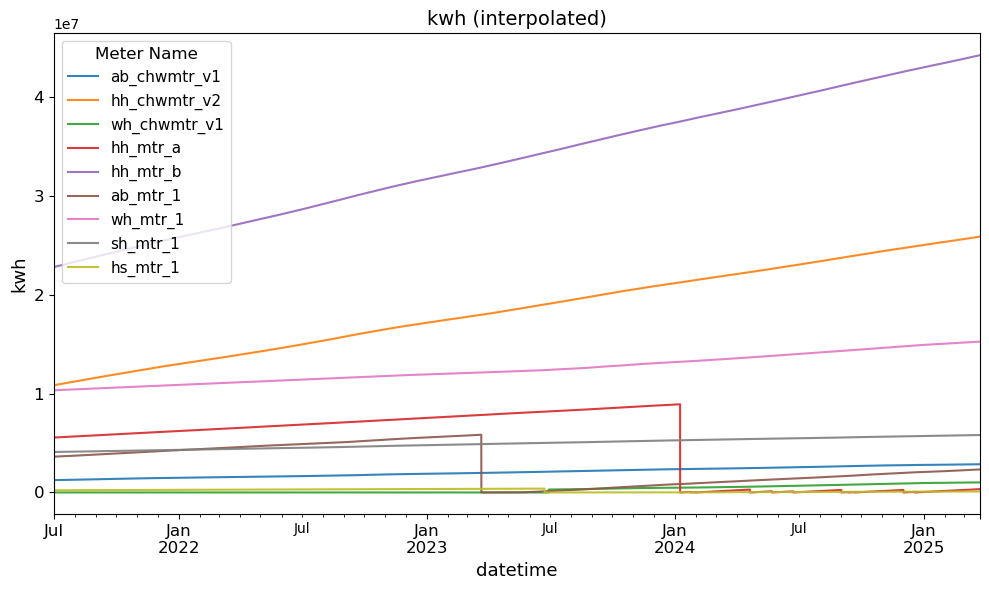

In [10]:
dc.plot_data(data,var, "interpolated", plot_dir)

##### <span style="color:blue">Combine data with interpolation_flags and Reshape the dataframe:</span>

In [11]:
final_df = dc.reshape_interpolated_data(data, interpolation_flags)

# Replace 0 value with NaN missing value
final_df['meter_reading'] = final_df['meter_reading'].replace(0, np.nan)

# Add an 'is_missing' column: 1 for missing values, 0 otherwise
final_df['is_missing'] = final_df['meter_reading'].isna().astype(int)

display(Markdown(f"<span style='color:blue; font-weight:bold'>Table of Interpolated {var}:</span>"))
final_df.head(10)

<span style='color:blue; font-weight:bold'>Table of Interpolated kwh:</span>

,datetime,meter_name,meter_reading,is_interpolated,is_missing
0,2021-07-01 00:00:00,ab_chwmtr_v1,1249797.02,0,0
1,2021-07-01 00:00:00,ab_mtr_1,3622764.00,0,0
2,2021-07-01 00:00:00,hh_chwmtr_v2,10854315.46,0,0
3,2021-07-01 00:00:00,hh_mtr_a,5559925.00,0,0
4,2021-07-01 00:00:00,hh_mtr_b,22813084.00,0,0
5,2021-07-01 00:00:00,hs_mtr_1,221368.00,0,0
6,2021-07-01 00:00:00,sh_mtr_1,4095888.00,0,0
7,2021-07-01 00:00:00,wh_chwmtr_v1,NaN,0,1
8,2021-07-01 00:00:00,wh_mtr_1,10339308.00,0,0
9,2021-07-01 00:15:00,ab_chwmtr_v1,1249806.92,0,0


### 2.3 Save Data for Uploading (Interpolated)<a id='2.3'></a>

In [12]:
# Create the file name with the variable
file_name_i = f"{var}_{schema}_{min_datetime}_{max_datetime}_interpolated.csv"
# Save file
dc.save_file(final_df, file_name_i, output_dir)  # for uploading

Writing file: "../../data/outputs/kwh_vitality_v5_2021-07-01_00-00-00_2025-03-24_23-45-00_interpolated.csv"


## 3. Interval<a id='3'></a>

### 3.1 Calculate Interval<a id='3.1'></a>

In [13]:
delta_df = dc.calculate_delta_df(data, freq)

##### <span style="color:blue">Plot Interval:</span>

Plot saved to ../../data/outputs/plots/kwh_interval.pdf


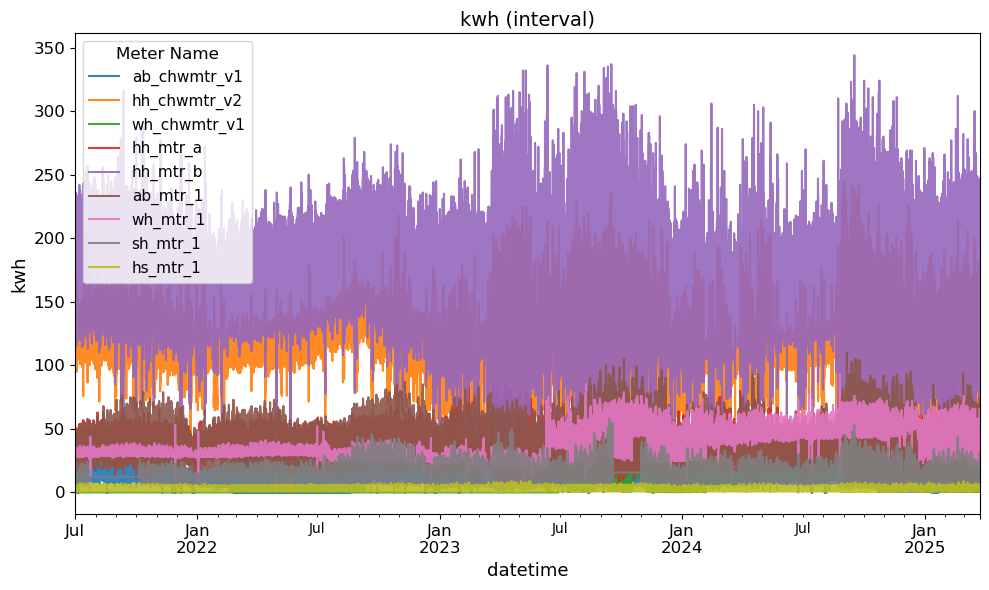

In [14]:
dc.plot_data(delta_df,var, "interval", plot_dir)

##### <span style="color:blue">Reshape dataframe:</span>

In [15]:
# Reshare dataframe for uplaoding
reshaped_delta_df = dc.reshape_delta_df(delta_df.reset_index(), var)

display(Markdown(f"<span style='color:blue; font-weight:bold'>Table of {var} Interval:</span>"))
reshaped_delta_df.head(18)

<span style='color:blue; font-weight:bold'>Table of kwh Interval:</span>

,datetime,meter_name,delta_kwh
0,2021-07-01 00:00:00,ab_chwmtr_v1,NaN
1,2021-07-01 00:00:00,ab_mtr_1,NaN
2,2021-07-01 00:00:00,hh_chwmtr_v2,NaN
3,2021-07-01 00:00:00,hh_mtr_a,NaN
4,2021-07-01 00:00:00,hh_mtr_b,NaN
5,2021-07-01 00:00:00,hs_mtr_1,NaN
6,2021-07-01 00:00:00,sh_mtr_1,NaN
7,2021-07-01 00:00:00,wh_chwmtr_v1,NaN
8,2021-07-01 00:00:00,wh_mtr_1,NaN
9,2021-07-01 00:15:00,ab_chwmtr_v1,9.9


### 3.2 Save Data for Uploading (Interval)<a id='3.2'></a>

In [16]:
# Create the file name with the variable
file_name_iv = f"{var}_{schema}_{min_datetime}_{max_datetime}_interval.csv"
# Save file
dc.save_file(delta_df.reset_index(), 'delta_'+var+".csv", output_dir)  # for calculating energy_disagg
dc.save_file(reshaped_delta_df, file_name_iv, output_dir)  # for uploading

Writing file: "../../data/outputs/delta_kwh.csv"
Writing file: "../../data/outputs/kwh_vitality_v5_2021-07-01_00-00-00_2025-03-24_23-45-00_interval.csv"
